In [1]:
import pyspark
import pandas as pd
from pyspark.sql.functions import *
from pyspark.ml.feature import StringIndexer,VectorAssembler
conf = pyspark.SparkConf().setAppName("odl").setMaster("local")
sc = pyspark.SparkContext(conf=conf)
sqlc = pyspark.sql.SQLContext(sc)

In [2]:
#Read in the file from s3
dataPath = "s3://odl-spark19spds6003-001/rz6dg/mushrooms.csv"
data = pd.read_csv(dataPath)

In [3]:
#print out the schema
df = sqlc.createDataFrame(data)
df.printSchema()

root
 |-- class: string (nullable = true)
 |-- cap-shape: string (nullable = true)
 |-- cap-surface: string (nullable = true)
 |-- cap-color: string (nullable = true)
 |-- bruises: string (nullable = true)
 |-- odor: string (nullable = true)
 |-- gill-attachment: string (nullable = true)
 |-- gill-spacing: string (nullable = true)
 |-- gill-size: string (nullable = true)
 |-- gill-color: string (nullable = true)
 |-- stalk-shape: string (nullable = true)
 |-- stalk-root: string (nullable = true)
 |-- stalk-surface-above-ring: string (nullable = true)
 |-- stalk-surface-below-ring: string (nullable = true)
 |-- stalk-color-above-ring: string (nullable = true)
 |-- stalk-color-below-ring: string (nullable = true)
 |-- veil-type: string (nullable = true)
 |-- veil-color: string (nullable = true)
 |-- ring-number: string (nullable = true)
 |-- ring-type: string (nullable = true)
 |-- spore-print-color: string (nullable = true)
 |-- population: string (nullable = true)
 |-- habitat: string 

# Convert file  into parque

In [16]:
parquetPath = '/home/ec2-user/SageMaker/rz6dg/parque'
df.write.parquet(parquetPath)

# Visulization

In [4]:
import seaborn as sns; sns.set();
import matplotlib.pyplot as plt

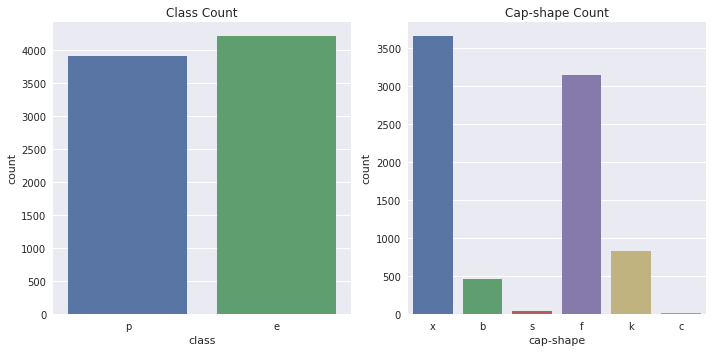

In [5]:
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(121)
sns.countplot(x="class", data=data)
plt.title("Class Count")
ax2 = fig.add_subplot(122)
sns.countplot(x="cap-shape", data=data)
plt.title("Cap-shape Count")
plt.tight_layout() 

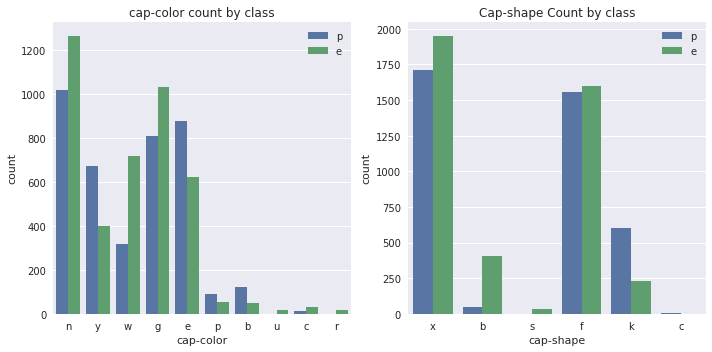

In [7]:
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(121)
sns.countplot(x="cap-color",hue="class", data=data)
plt.title("cap-color count by class")
plt.legend(loc="upper right")
ax2 = fig.add_subplot(122)
sns.countplot(x="cap-shape", hue="class", data=data)
plt.title("Cap-shape Count by class")
plt.legend(loc="upper right")
plt.tight_layout() 

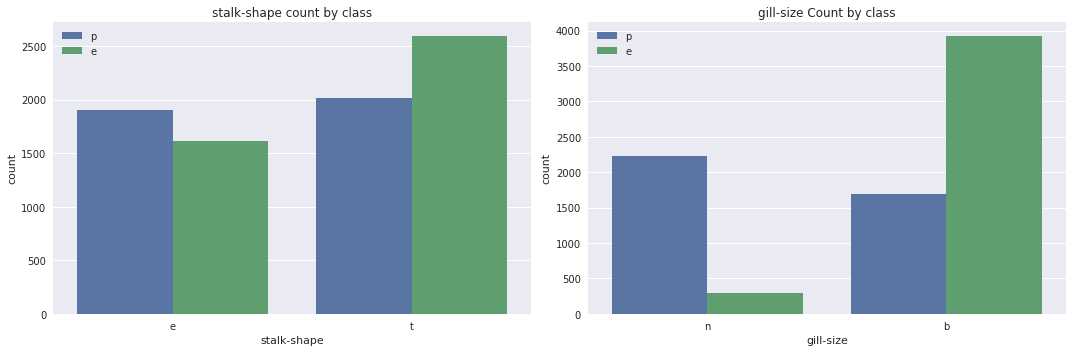

In [8]:
fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(121)
sns.countplot(x="stalk-shape",hue="class", data=data)
plt.title("stalk-shape count by class")
plt.legend(loc="upper left")
ax2 = fig.add_subplot(122)
sns.countplot(x="gill-size", hue="class", data=data)
plt.title("gill-size Count by class")
plt.legend(loc="upper left")
plt.tight_layout() 

# Label encoding

In [9]:
#use a loop to apply label encoding to all categorical variables
df1 = df
for col_name in df1.columns:
    indexer = StringIndexer(inputCol=col_name, outputCol="new_"+col_name)
    model = indexer.fit(df1)
    df1 = model.transform(df1)

In [10]:
# drop old columns
drop_list =['class','cap-shape',
 'cap-surface',
 'cap-color',
 'bruises',
 'odor',
 'gill-attachment',
 'gill-spacing',
 'gill-size',
 'gill-color',
 'stalk-shape',
 'stalk-root',
 'stalk-surface-above-ring',
 'stalk-surface-below-ring',
 'stalk-color-above-ring',
 'stalk-color-below-ring',
 'veil-type',
 'veil-color',
 'ring-number',
 'ring-type',
 'spore-print-color',
 'population',
 'habitat']
df2 = df1.drop(*drop_list)

In [11]:
# create train/test sets
from pyspark.ml.feature import StringIndexer,VectorAssembler
col_list = ['new_cap-shape',
 'new_cap-surface',
 'new_cap-color',
 'new_bruises',
 'new_odor',
 'new_gill-attachment',
 'new_gill-spacing',
 'new_gill-size',
 'new_gill-color',
 'new_stalk-shape',
 'new_stalk-root',
 'new_stalk-surface-above-ring',
 'new_stalk-surface-below-ring',
 'new_stalk-color-above-ring',
 'new_stalk-color-below-ring',
 'new_veil-type',
 'new_veil-color',
 'new_ring-number',
 'new_ring-type',
 'new_spore-print-color',
 'new_population',
 'new_habitat']
assemblerInputs = col_list
#vectorization
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
df3 = assembler.transform(df2)
#change column name
df3 = df3.withColumn("label",df3.new_class)
#split data into trainning set and test set
seed = 42
(test, train) = df3.randomSplit((0.20, 0.80), seed=seed)
print ('training set N = {}, test set N = {}'.format(train.count(),test.count()))

training set N = 6484, test set N = 1640


# RandomForest

In [12]:
#create a model using randomforest
from pyspark.ml.classification import RandomForestClassifier
rf = RandomForestClassifier(featuresCol ="features", labelCol = 'label')
rfModel = rf.fit(train)
predictions = rfModel.transform(test)

In [13]:
predictions.select('label', 'rawPrediction', 'prediction', 'probability').show(100)

+-----+--------------------+----------+--------------------+
|label|       rawPrediction|prediction|         probability|
+-----+--------------------+----------+--------------------+
|  0.0|[18.9109593236013...|       0.0|[0.94554796618006...|
|  0.0|[19.2961920207710...|       0.0|[0.96480960103855...|
|  0.0|[19.3595523581399...|       0.0|[0.96797761790699...|
|  0.0|[19.7447850553096...|       0.0|[0.98723925276548...|
|  0.0|[19.4281949128708...|       0.0|[0.97140974564354...|
|  0.0|[19.4815067060857...|       0.0|[0.97407533530428...|
|  0.0|[19.4281949128708...|       0.0|[0.97140974564354...|
|  0.0|[19.8767879474094...|       0.0|[0.99383939737047...|
|  0.0|[19.8767879474094...|       0.0|[0.99383939737047...|
|  0.0|[19.8767879474094...|       0.0|[0.99383939737047...|
|  0.0|[19.2972418785153...|       0.0|[0.96486209392576...|
|  0.0|[19.2972418785153...|       0.0|[0.96486209392576...|
|  0.0|[18.9928804904539...|       0.0|[0.94964402452269...|
|  0.0|[19.7945588109657

In [14]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator()
#Area under score
print('Test Area Under ROC', evaluator.evaluate(predictions))

Test Area Under ROC 1.0


In [15]:
print(evaluator.explainParams())

labelCol: label column name. (default: label)
metricName: metric name in evaluation (areaUnderROC|areaUnderPR) (default: areaUnderROC)
rawPredictionCol: raw prediction (a.k.a. confidence) column name. (default: rawPrediction)


In [16]:
#print out feature importance
print(rfModel.featureImportances)

(22,[0,1,2,3,4,6,7,8,9,10,11,12,13,14,17,18,19,20,21],[0.002149904689318004,0.004633216016254301,0.010450661330919682,0.0026044404410046134,0.39919007303151577,0.02219094164396756,0.050741328123364404,0.09329931063101916,0.013879105671704311,0.01638665972565937,0.13687684067435923,0.00590346854176021,0.004114371702562977,0.0048175467716775975,0.025738367461111918,0.04993963460404492,0.11267949096941035,0.03512947640116608,0.00927516156917951])


# Logistic Regression

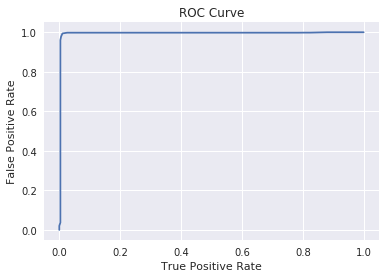

In [17]:
#create a logistic regression model 
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=10)
lrModel = lr.fit(train)
trainingSummary = lrModel.summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

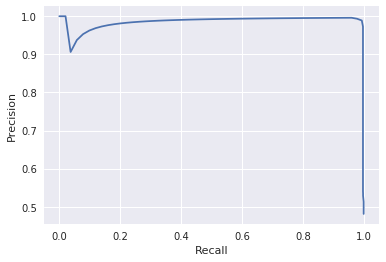

In [18]:
#Precision and recall
pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()


In [19]:
#prediction
predictions = lrModel.transform(test)
predictions.select('label', 'rawPrediction', 'prediction', 'probability').show(10)

+-----+--------------------+----------+--------------------+
|label|       rawPrediction|prediction|         probability|
+-----+--------------------+----------+--------------------+
|  0.0|[3.59986582692035...|       0.0|[0.97339953251599...|
|  0.0|[3.85053531188775...|       0.0|[0.97917457421590...|
|  0.0|[3.71151230671631...|       0.0|[0.97614255496437...|
|  0.0|[3.96218179168371...|       0.0|[0.98133349824369...|
|  0.0|[3.64254182681792...|       0.0|[0.97448249396379...|
|  0.0|[3.89321131178532...|       0.0|[0.98002724567206...|
|  0.0|[3.34910679008008...|       0.0|[0.96607557435642...|
|  0.0|[3.46075326987603...|       0.0|[0.96955021308607...|
|  0.0|[3.50342926977361...|       0.0|[0.97078518500766...|
|  0.0|[3.90851078630741...|       0.0|[0.98032452611536...|
+-----+--------------------+----------+--------------------+
only showing top 10 rows



# Model evaluation

In [20]:
evaluator = BinaryClassificationEvaluator()
print('Test Area Under ROC', evaluator.evaluate(predictions))
print(predictions.orderBy(predictions.label.desc()).take(5))

Test Area Under ROC 0.9943824573102535
[Row(new_class=1.0, new_cap-shape=0.0, new_cap-surface=0.0, new_cap-color=0.0, new_bruises=0.0, new_odor=1.0, new_gill-attachment=0.0, new_gill-spacing=0.0, new_gill-size=1.0, new_gill-color=0.0, new_stalk-shape=0.0, new_stalk-root=1.0, new_stalk-surface-above-ring=0.0, new_stalk-surface-below-ring=0.0, new_stalk-color-above-ring=0.0, new_stalk-color-below-ring=1.0, new_veil-type=0.0, new_veil-color=0.0, new_ring-number=0.0, new_ring-type=1.0, new_spore-print-color=0.0, new_population=0.0, new_habitat=0.0, features=SparseVector(22, {4: 1.0, 7: 1.0, 10: 1.0, 14: 1.0, 18: 1.0}), label=1.0, rawPrediction=DenseVector([-0.3636, 0.3636]), probability=DenseVector([0.4101, 0.5899]), prediction=1.0), Row(new_class=1.0, new_cap-shape=0.0, new_cap-surface=0.0, new_cap-color=0.0, new_bruises=0.0, new_odor=1.0, new_gill-attachment=0.0, new_gill-spacing=0.0, new_gill-size=1.0, new_gill-color=0.0, new_stalk-shape=0.0, new_stalk-root=1.0, new_stalk-surface-above-

In [21]:
pred = predictions.select("prediction","label").toPandas()

In [26]:
#Create a confusion matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(pred.label,pred.prediction)

array([[836,   8],
       [  6, 790]])

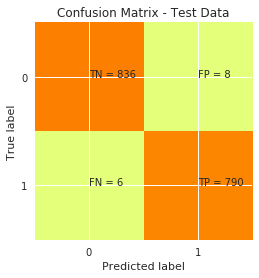

In [30]:
#visulize the confusion matrix
import numpy as np
cm = confusion_matrix(pred.label,pred.prediction)
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['0','1']
plt.title('Confusion Matrix - Test Data')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))